In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', 500)

In [3]:
from utils import load_fold
train, test, test_fold = load_fold('Raw', 5)

Test fold: MYC.csv
Train fold: CTNNB1.csv
Train fold: LEF1.csv
Train fold: Jnk.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: Ikk2.csv


### Group-wise shuffle

In [4]:
def group_wise_shuffle(df):
    aux = df.values.reshape((-1, 6, df.shape[1]))
    np.random.shuffle(aux)
    aux = aux.reshape((-1, df.shape[1]))
    return pd.DataFrame(aux, columns=df.columns)

In [5]:
X_train_cause = train[[col for col in train.columns if 'cause' in col]]
X_train_effect = train[[col for col in train.columns if 'effect' in col]]
y_train = train['Target']

In [6]:
X_train = np.array([np.outer(cause, effect) for cause, effect in \
             zip(X_train_cause.values, X_train_effect.values)])

In [7]:
X_train.shape, y_train.shape

((709578, 9, 9), (709578,))

In [8]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_train.reshape(-1, 81), y_train)
X_resampled = X_resampled.reshape(-1, 9, 9)

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
def create_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(9, 9, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, (3, 3), strides=2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, (1, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
       
#     model.add(GlobalAveragePooling2D())
#     model.add(Activation('softmax'))

    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [11]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 16)          160       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 16)          64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 32)          128       
__________

In [12]:
model = KerasClassifier(create_model)

In [13]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='_data/model.best.hdf5',
                               verbose=1, save_best_only=True)

In [18]:
history = model.fit(X_resampled.reshape(-1, 9, 9, 1), y_resampled, 
                     batch_size=128, epochs=100, verbose=1, 
                     callbacks=[checkpointer], shuffle=True)

Epoch 1/100
24360/24360 [==============================] - 2s 88us/step - loss: 0.8940 - acc: 0.5189
Epoch 2/100
 2432/24360 [=>............................] - ETA: 1s - loss: 0.7848 - acc: 0.5045

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/keras/callbacks.py:406: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


24360/24360 [==============================] - 1s 61us/step - loss: 0.7486 - acc: 0.5303
Epoch 3/100
24360/24360 [==============================] - 2s 77us/step - loss: 0.7059 - acc: 0.5509
Epoch 4/100
24360/24360 [==============================] - 2s 74us/step - loss: 0.6820 - acc: 0.5704
Epoch 5/100
24360/24360 [==============================] - 2s 76us/step - loss: 0.6695 - acc: 0.5959
Epoch 6/100
24360/24360 [==============================] - 2s 71us/step - loss: 0.6536 - acc: 0.6177
Epoch 7/100
24360/24360 [==============================] - 2s 66us/step - loss: 0.6417 - acc: 0.6323
Epoch 8/100
24360/24360 [==============================] - 2s 64us/step - loss: 0.6300 - acc: 0.6463
Epoch 9/100
24360/24360 [==============================] - 1s 61us/step - loss: 0.6205 - acc: 0.6524
Epoch 10/100
24360/24360 [==============================] - 2s 73us/step - loss: 0.6130 - acc: 0.6647
Epoch 11/100
24360/24360 [==============================] - 1s 61us/step - loss: 0.6050 - acc: 0.6708


KeyboardInterrupt: 

In [181]:
history3 = model.fit(X_resampled.reshape(-1, 9, 9, 1), y_resampled, 
                     batch_size=128, epochs=100, verbose=1, 
                     callbacks=[checkpointer], shuffle=True
                     validation_data=(X_val, y_val))

Epoch 1/100
35292/35292 [==============================] - 8s - loss: 0.7689 - acc: 0.5281     
Epoch 2/100
35292/35292 [==============================] - 7s - loss: 0.6812 - acc: 0.5696     
Epoch 3/100
35292/35292 [==============================] - 7s - loss: 0.6583 - acc: 0.6075     
Epoch 4/100
35292/35292 [==============================] - 7s - loss: 0.6328 - acc: 0.6437     
Epoch 5/100
35292/35292 [==============================] - 7s - loss: 0.6114 - acc: 0.6668     
Epoch 6/100
35292/35292 [==============================] - 7s - loss: 0.5985 - acc: 0.6771     
Epoch 7/100
35292/35292 [==============================] - 7s - loss: 0.5877 - acc: 0.6879     
Epoch 8/100
35292/35292 [==============================] - 7s - loss: 0.5807 - acc: 0.6945     
Epoch 9/100
35292/35292 [==============================] - 7s - loss: 0.5710 - acc: 0.7012     
Epoch 10/100
35292/35292 [==============================] - 7s - loss: 0.5660 - acc: 0.7063     
Epoch 11/100
35292/35292 [=============

In [182]:
# conv pooling dense dense
# conv pooling dense
# conv dense
# conv dense (no dropout)

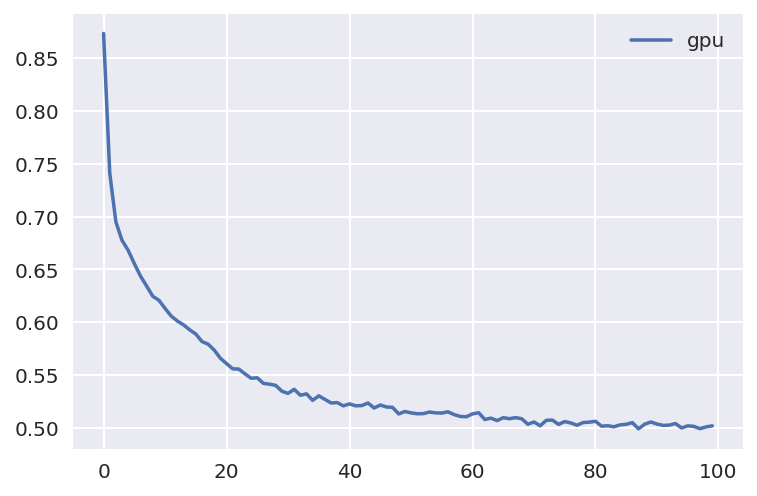

In [17]:
pd.Series(history3.history['loss'], name='gpu').plot()
plt.legend()

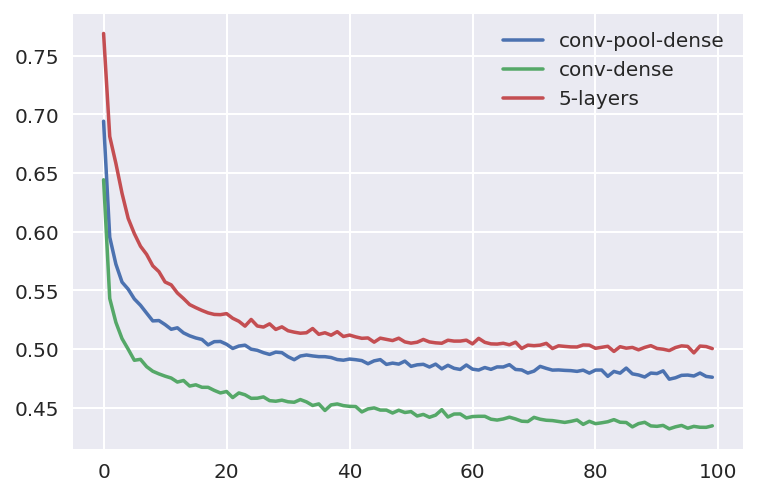

In [183]:
pd.Series(history.history['loss'], name='conv-pool-dense').plot()
pd.Series(history2.history['loss'], name='conv-dense').plot()
pd.Series(history3.history['loss'], name='5-layers').plot()
plt.legend()

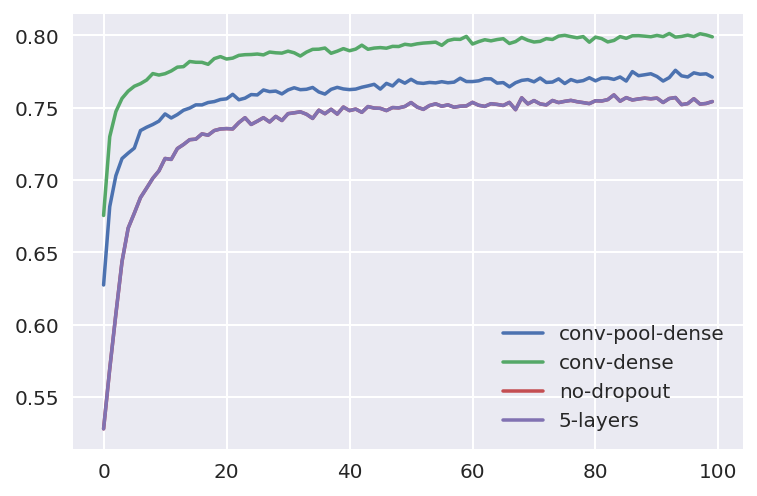

In [184]:
pd.Series(history.history['acc'], name='conv-pool-dense').plot()
pd.Series(history2.history['acc'], name='conv-dense').plot()
pd.Series(history3.history['acc'], name='no-dropout').plot()
pd.Series(history3.history['acc'], name='5-layers').plot()
plt.legend()

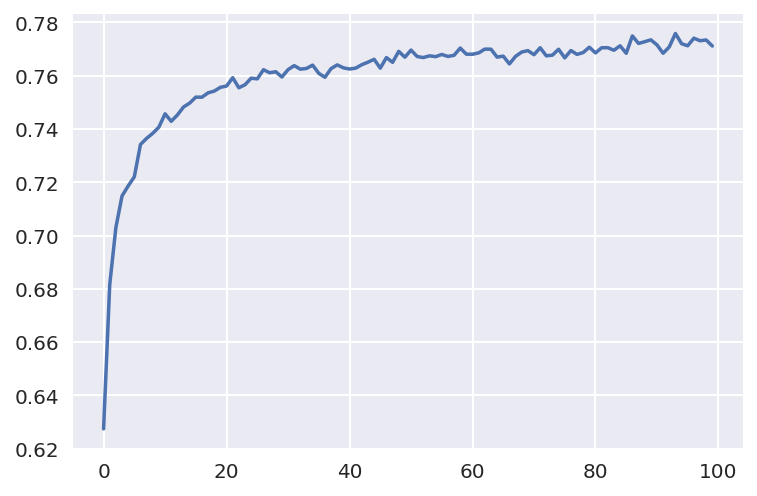

In [153]:
pd.Series(history.history['acc']).plot()

In [140]:
model.fit(X_resampled.reshape(-1, 9, 9, 1), y_resampled)

Epoch 1/100
35292/35292 [==============================] - 5s - loss: 0.7435 - acc: 0.5824     
Epoch 2/100
35292/35292 [==============================] - 5s - loss: 0.6252 - acc: 0.6491     
Epoch 3/100
35292/35292 [==============================] - 5s - loss: 0.5990 - acc: 0.6741     
Epoch 4/100
35292/35292 [==============================] - 5s - loss: 0.5818 - acc: 0.6927     
Epoch 5/100
35292/35292 [==============================] - 5s - loss: 0.5675 - acc: 0.7059     
Epoch 6/100
35292/35292 [==============================] - 5s - loss: 0.5584 - acc: 0.7155     
Epoch 7/100
35292/35292 [==============================] - 5s - loss: 0.5478 - acc: 0.7233     
Epoch 8/100
35292/35292 [==============================] - 5s - loss: 0.5415 - acc: 0.7287     
Epoch 9/100
35292/35292 [==============================] - 5s - loss: 0.5379 - acc: 0.7311     
Epoch 10/100
35292/35292 [==============================] - 5s - loss: 0.5302 - acc: 0.7369     
Epoch 11/100
35292/35292 [=============

## GBM Baseline

In [103]:
from catboost import CatBoostClassifier

In [104]:
gbm = CatBoostClassifier()

In [105]:
gbm.fit(X_resampled.reshape(-1, 81), y_resampled)

0: learn: 0.6894897	total: 179ms	remaining: 2m 58s
1: learn: 0.6860596	total: 262ms	remaining: 2m 10s
2: learn: 0.6813949	total: 313ms	remaining: 1m 44s
3: learn: 0.676023	total: 373ms	remaining: 1m 32s
4: learn: 0.672265	total: 424ms	remaining: 1m 24s
5: learn: 0.669232	total: 494ms	remaining: 1m 21s
6: learn: 0.6655652	total: 546ms	remaining: 1m 17s
7: learn: 0.6615584	total: 605ms	remaining: 1m 15s
8: learn: 0.6585079	total: 668ms	remaining: 1m 13s
9: learn: 0.6558013	total: 727ms	remaining: 1m 11s
10: learn: 0.6531971	total: 778ms	remaining: 1m 9s
11: learn: 0.6500331	total: 886ms	remaining: 1m 12s
12: learn: 0.6475152	total: 975ms	remaining: 1m 13s
13: learn: 0.6459346	total: 1.05s	remaining: 1m 13s
14: learn: 0.6441278	total: 1.12s	remaining: 1m 13s
15: learn: 0.6427574	total: 1.21s	remaining: 1m 14s
16: learn: 0.6408434	total: 1.28s	remaining: 1m 14s
17: learn: 0.637586	total: 1.36s	remaining: 1m 14s
18: learn: 0.6350324	total: 1.45s	remaining: 1m 14s
19: learn: 0.6336769	total:

158: learn: 0.5288901	total: 15.7s	remaining: 1m 23s
159: learn: 0.5284329	total: 15.8s	remaining: 1m 22s
160: learn: 0.5281231	total: 15.9s	remaining: 1m 22s
161: learn: 0.5277107	total: 16s	remaining: 1m 22s
162: learn: 0.5273052	total: 16.1s	remaining: 1m 22s
163: learn: 0.5268847	total: 16.2s	remaining: 1m 22s
164: learn: 0.5264745	total: 16.3s	remaining: 1m 22s
165: learn: 0.5261264	total: 16.4s	remaining: 1m 22s
166: learn: 0.5258293	total: 16.5s	remaining: 1m 22s
167: learn: 0.5254988	total: 16.6s	remaining: 1m 22s
168: learn: 0.5250856	total: 16.7s	remaining: 1m 22s
169: learn: 0.5246782	total: 16.8s	remaining: 1m 22s
170: learn: 0.5243617	total: 16.9s	remaining: 1m 22s
171: learn: 0.5239653	total: 17s	remaining: 1m 22s
172: learn: 0.5236088	total: 17.2s	remaining: 1m 22s
173: learn: 0.5234555	total: 17.3s	remaining: 1m 22s
174: learn: 0.5229009	total: 17.4s	remaining: 1m 22s
175: learn: 0.5224362	total: 17.5s	remaining: 1m 22s
176: learn: 0.5222217	total: 17.6s	remaining: 1m 2

315: learn: 0.4880616	total: 34.5s	remaining: 1m 14s
316: learn: 0.4878618	total: 34.6s	remaining: 1m 14s
317: learn: 0.4876476	total: 34.8s	remaining: 1m 14s
318: learn: 0.4873265	total: 34.9s	remaining: 1m 14s
319: learn: 0.4868648	total: 35.1s	remaining: 1m 14s
320: learn: 0.4867114	total: 35.2s	remaining: 1m 14s
321: learn: 0.4865632	total: 35.4s	remaining: 1m 14s
322: learn: 0.4861341	total: 35.5s	remaining: 1m 14s
323: learn: 0.4860073	total: 35.7s	remaining: 1m 14s
324: learn: 0.4857043	total: 35.8s	remaining: 1m 14s
325: learn: 0.4855219	total: 36s	remaining: 1m 14s
326: learn: 0.4853884	total: 36.1s	remaining: 1m 14s
327: learn: 0.4851566	total: 36.3s	remaining: 1m 14s
328: learn: 0.4849553	total: 36.4s	remaining: 1m 14s
329: learn: 0.484801	total: 36.7s	remaining: 1m 14s
330: learn: 0.484634	total: 36.9s	remaining: 1m 14s
331: learn: 0.4844724	total: 37s	remaining: 1m 14s
332: learn: 0.4843359	total: 37.2s	remaining: 1m 14s
333: learn: 0.4841275	total: 37.3s	remaining: 1m 14s

472: learn: 0.4616601	total: 1m 1s	remaining: 1m 8s
473: learn: 0.4615243	total: 1m 1s	remaining: 1m 8s
474: learn: 0.4614038	total: 1m 1s	remaining: 1m 7s
475: learn: 0.4613376	total: 1m 1s	remaining: 1m 7s
476: learn: 0.4611986	total: 1m 1s	remaining: 1m 7s
477: learn: 0.4610386	total: 1m 1s	remaining: 1m 7s
478: learn: 0.4609134	total: 1m 2s	remaining: 1m 7s
479: learn: 0.4607957	total: 1m 2s	remaining: 1m 7s
480: learn: 0.4606399	total: 1m 2s	remaining: 1m 7s
481: learn: 0.4605058	total: 1m 2s	remaining: 1m 7s
482: learn: 0.4603949	total: 1m 2s	remaining: 1m 6s
483: learn: 0.4602408	total: 1m 2s	remaining: 1m 6s
484: learn: 0.4601455	total: 1m 2s	remaining: 1m 6s
485: learn: 0.4600356	total: 1m 2s	remaining: 1m 6s
486: learn: 0.4598132	total: 1m 2s	remaining: 1m 6s
487: learn: 0.4596987	total: 1m 3s	remaining: 1m 6s
488: learn: 0.4595913	total: 1m 3s	remaining: 1m 6s
489: learn: 0.4593982	total: 1m 3s	remaining: 1m 5s
490: learn: 0.4592442	total: 1m 3s	remaining: 1m 5s
491: learn: 

630: learn: 0.4429068	total: 1m 20s	remaining: 47.2s
631: learn: 0.4428052	total: 1m 20s	remaining: 47.1s
632: learn: 0.4427209	total: 1m 20s	remaining: 46.9s
633: learn: 0.4426504	total: 1m 21s	remaining: 46.8s
634: learn: 0.4425466	total: 1m 21s	remaining: 46.6s
635: learn: 0.442439	total: 1m 21s	remaining: 46.5s
636: learn: 0.4423011	total: 1m 21s	remaining: 46.4s
637: learn: 0.442184	total: 1m 21s	remaining: 46.2s
638: learn: 0.4420556	total: 1m 21s	remaining: 46.1s
639: learn: 0.4419529	total: 1m 21s	remaining: 46s
640: learn: 0.4418483	total: 1m 21s	remaining: 45.9s
641: learn: 0.4417578	total: 1m 22s	remaining: 45.7s
642: learn: 0.4417101	total: 1m 22s	remaining: 45.6s
643: learn: 0.441578	total: 1m 22s	remaining: 45.5s
644: learn: 0.4414752	total: 1m 22s	remaining: 45.3s
645: learn: 0.4413765	total: 1m 22s	remaining: 45.2s
646: learn: 0.4411731	total: 1m 22s	remaining: 45.1s
647: learn: 0.4410624	total: 1m 22s	remaining: 45s
648: learn: 0.440969	total: 1m 22s	remaining: 44.8s
6

787: learn: 0.4280366	total: 1m 40s	remaining: 27s
788: learn: 0.427934	total: 1m 40s	remaining: 26.8s
789: learn: 0.4278572	total: 1m 40s	remaining: 26.7s
790: learn: 0.4277266	total: 1m 40s	remaining: 26.6s
791: learn: 0.4276297	total: 1m 40s	remaining: 26.5s
792: learn: 0.4275599	total: 1m 40s	remaining: 26.4s
793: learn: 0.4274521	total: 1m 41s	remaining: 26.3s
794: learn: 0.4273699	total: 1m 41s	remaining: 26.1s
795: learn: 0.4272885	total: 1m 41s	remaining: 26s
796: learn: 0.4272213	total: 1m 41s	remaining: 25.9s
797: learn: 0.4271345	total: 1m 41s	remaining: 25.8s
798: learn: 0.4270342	total: 1m 42s	remaining: 25.7s
799: learn: 0.4269278	total: 1m 42s	remaining: 25.6s
800: learn: 0.4268515	total: 1m 42s	remaining: 25.4s
801: learn: 0.4267703	total: 1m 42s	remaining: 25.3s
802: learn: 0.4266815	total: 1m 42s	remaining: 25.2s
803: learn: 0.4266023	total: 1m 42s	remaining: 25.1s
804: learn: 0.4265104	total: 1m 42s	remaining: 24.9s
805: learn: 0.4264472	total: 1m 43s	remaining: 24.8

945: learn: 0.4155338	total: 2m 5s	remaining: 7.15s
946: learn: 0.4154678	total: 2m 5s	remaining: 7.01s
947: learn: 0.415427	total: 2m 5s	remaining: 6.88s
948: learn: 0.4153325	total: 2m 5s	remaining: 6.75s
949: learn: 0.4152446	total: 2m 5s	remaining: 6.62s
950: learn: 0.4151576	total: 2m 5s	remaining: 6.49s
951: learn: 0.4150856	total: 2m 6s	remaining: 6.36s
952: learn: 0.4149836	total: 2m 6s	remaining: 6.23s
953: learn: 0.4149115	total: 2m 6s	remaining: 6.1s
954: learn: 0.4148319	total: 2m 6s	remaining: 5.96s
955: learn: 0.41476	total: 2m 6s	remaining: 5.83s
956: learn: 0.4146793	total: 2m 6s	remaining: 5.7s
957: learn: 0.4146206	total: 2m 7s	remaining: 5.57s
958: learn: 0.4145744	total: 2m 7s	remaining: 5.44s
959: learn: 0.4145049	total: 2m 7s	remaining: 5.31s
960: learn: 0.4144257	total: 2m 7s	remaining: 5.18s
961: learn: 0.414378	total: 2m 7s	remaining: 5.05s
962: learn: 0.4142905	total: 2m 7s	remaining: 4.91s
963: learn: 0.4142252	total: 2m 8s	remaining: 4.78s
964: learn: 0.4141

In [110]:
y_proba = gbm.predict_proba(X_resampled.reshape(-1, 81))
y = gbm.predict(X_resampled.reshape(-1, 81))

In [111]:
from sklearn.metrics import accuracy_score

In [114]:
pd.Series(y_resampled).value_counts()

1    17646
0    17646
dtype: int64

In [112]:
accuracy_score(y_resampled, y)

0.8252861838376969